In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from uproot_io import Events, View

In [3]:
events = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_1.root")

In [4]:
#TO FIT STRAIGHT LINES

def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def fitting(event_number, plot):
    idx = np.where(events.event_number == event_number)[0]
    resis = []
    gradients = []
    intercepts = []
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    if plot == True:
        plt.scatter(vx, vz, c='red', s=50)

    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x0, z0, s=0.5)
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)
        
    if vx < xmin:
        xmin = vx    
    if vx > xmax:
        xmax = vx
    if vz < zmin:
        zmin = vz    
    if vz > zmax:
        zmax = vz

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    if plot == True:
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
        plt.show()
        
        plt.scatter(vx, vz, c='red', s=50)
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
    
    particleType = np.array([])
    
    for i in idx:
        pdg = events.mc_pdg[i]
        particleType = np.append(particleType, pdg)
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x, z, s=0.5)
                
        best_inliers = []
        best_model = None
        sample_size = 10
        max_iterations = 100
        #inlier_threshold = 2.0
        
        for _ in range(max_iterations):
            sample_size = min(sample_size, len(x))
            sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
            x_sample = x[sample_indices]
            z_sample = z[sample_indices]

            m, c = fit_line(x_sample, z_sample)
            residuals = calculate_residuals(x, z, m, c)
            inliers = np.where(residuals < (0.15*xlen))[0]

            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_model = (m, c)

        if len(best_inliers) > 0:
            m, c = best_model
            gradients.append(m)
            intercepts.append(c)
            
            if plot == True:
                x_inliers = x[best_inliers]
                z_inliers = z[best_inliers]
                plt.scatter(x_inliers, z_inliers, color='blue', marker='o')

                plt.plot(x_inliers, m * x_inliers + c)
                plt.xlabel('x')
                plt.ylabel('w')
                plt.show()
        
            perp_dist = [calculate_residuals(x[i], z[i], m, c) for i in range(len(x))]
            num_points = int(0.5 * len(x))
            mean = np.mean(perp_dist[:num_points])
            resis.append(mean)
        else:
            gradients.append(0)
            intercepts.append(0)
            resis.append(0)
            #print("No inliers found for a particle")
            continue
    
    return gradients, intercepts, resis, particleType

In [5]:
def symmetry(event_number):
    """Returns a measure of symmetry for each particle's track by dividing how many are 
    above line of best fit by how many are below the line (or the absolute value of the difference?)"""
    
    particleType = np.array([])
    allSym = np.array([])
    
    m, c, _, _ = fitting(event_number, False)
    
    idx = np.where(events.event_number == event_number)[0]
    
    for i in idx:
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        
        
        # Discarding particles with little hits
        if x.size <= 100:
            continue
            
        else:   
            # Changing coordinates to along and transverse
            if m[i-idx[0]] == 0:
                continue
            else:
                znew = z - c[i-idx[0]]
                angle = -math.atan(m[i-idx[0]])
                l = x * np.cos(angle) - znew * np.sin(angle)
                t = x * np.sin(angle) + znew * np.cos(angle)
                
                # How many particles are above or below the line?
                above = np.sum(t > 0)
                below = np.sum(t < 0)
                
                lmin, lmax = np.min(l), np.max(l)
                length = lmax - lmin

                
                if above == 0 or below == 0 or length == 0:
                    continue
                    
                else:
                    
                    sym = (above + below) / length
                    allSym = np.append(allSym, sym)
                    
                    pdg = events.mc_pdg[i]
                    particleType = np.append(particleType, pdg)
                    
                    
#                     if above > below:
#                         sym = above / below
#                         allSym = np.append(allSym, sym)
                        
#                         pdg = events.mc_pdg[i]
#                         particleType = np.append(particleType, pdg)
                        
#                     else:
#                         sym = below / above
#                         allSym = np.append(allSym, sym)
        
#                         pdg = events.mc_pdg[i]
#                         particleType = np.append(particleType, pdg)
                
#                     plt.scatter(x,z)
#                     plt.show()
                    
#                     plt.scatter(l,t, label= f"X = {sym}")
#                     plt.legend()
#                     plt.show()
                
    return allSym, particleType

In [6]:
symmetry(123)

/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(array([2.09551616]), array([13.]))

In [7]:
random_numbers = np.random.randint(0, max(events.event_number), 500)

In [10]:
s = []
p = []
iteration = 0
for i in random_numbers:
    s, p = np.append(s, symmetry(i)[0]), np.append(p, symmetry(i)[1])
    print(f"Iteration number: {iteration}")
    iteration += 1  # Increment the counter

Iteration number: 0
Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10
Iteration number: 11
Iteration number: 12
Iteration number: 13
Iteration number: 14
Iteration number: 15
Iteration number: 16
Iteration number: 17
Iteration number: 18
Iteration number: 19
Iteration number: 20
Iteration number: 21
Iteration number: 22
Iteration number: 23
Iteration number: 24
Iteration number: 25
Iteration number: 26
Iteration number: 27
Iteration number: 28
Iteration number: 29
Iteration number: 30
Iteration number: 31
Iteration number: 32
Iteration number: 33
Iteration number: 34
Iteration number: 35
Iteration number: 36
Iteration number: 37
Iteration number: 38
Iteration number: 39
Iteration number: 40
Iteration number: 41
Iteration number: 42
Iteration number: 43
Iteration number: 44
Iteration number: 45
Iteration number: 46
Iteration number: 47
It

KeyboardInterrupt: 

In [11]:
s.shape, p.shape

((1230,), (1230,))

In [85]:
df = pd.DataFrame({"symmetry": s, "particle": p})

In [86]:
# Using 0 to indicate tracks, 1 to indicate showers.

mapping = {
    11: 1,
    -11: 1,
    22: 1
}

df["class"] = df["particle"].map(mapping).fillna(0)

In [87]:
tracksQuery = df['class'] == 0.0
showersQuery = df['class'] == 1.0

ftracks = df[tracksQuery]
fshowers = df[showersQuery]

tracks = ftracks['symmetry'].values
showers = fshowers['symmetry'].values

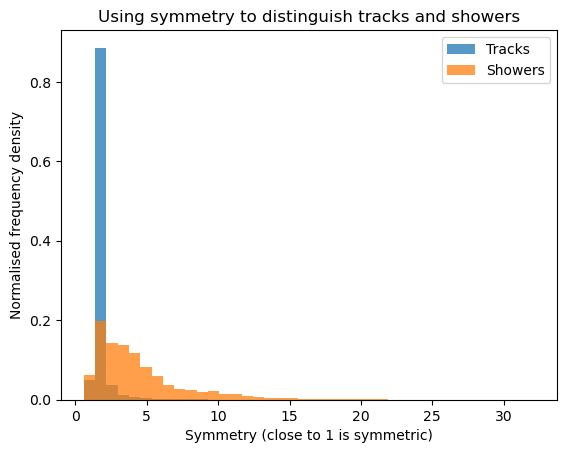

In [88]:
n_bins = 40
hist2, bin_edges = np.histogram(showers, bins=n_bins)
hist1, _ = np.histogram(tracks, bins=bin_edges)

bin_widths = np.diff(bin_edges)
    
hist1_normalized = hist1 / len(tracks)
hist2_normalized = hist2 / len(showers)

plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.75, label='Tracks')
plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.75, label='Showers')
plt.title("Using symmetry to distinguish tracks and showers")
plt.ylabel("Normalised frequency density")
plt.xlabel("Symmetry (close to 1 is symmetric)")
# plt.xlim(-1, 30)

plt.legend()
plt.show()

In [34]:
random_numbers

array([4529, 8706,  835, 3510, 3443, 1487, 5484, 5516,  751, 7811, 4849,
        342, 5600, 7340, 7915, 4500, 6797, 1682,  328, 5277, 5864, 1955,
       1157,    5, 4884, 5289, 2286, 3249, 6114, 4340, 1569, 8487, 7464,
       9013,   69, 2851, 6992, 4944, 7431, 8550, 2696, 8254, 3196, 6996,
       1183,  293, 2689, 3113, 7889, 1582, 4242, 6346, 2689, 3542, 8840,
       1504, 4961, 6322, 8296, 1169, 1377, 1892, 6505, 1359, 2885,  407,
       6090, 5384, 2464, 3599, 7345,  997, 6969, 6399, 2310, 8133, 2119,
       5163, 2148, 4596, 1698, 5096, 4292,  245, 8273, 6591, 4094, 5176,
       8917, 5513, 8730, 3199, 6665,  305, 3655, 8086, 6080, 3136, 2125,
       6363, 6764, 8004, 2250, 2953, 3082, 4295, 5654, 1632, 4967, 2934,
       7065, 4429, 4378, 3215,  483, 8283, 4320, 1393, 6634, 4992, 7543,
         99, 2500, 8610, 6003, 8747, 3785, 6979, 5561, 8028, 5607, 7389,
        276, 8522, 8066,  522, 1043, 1975, 4265, 2500, 4147, 4543,  756,
       2502, 4119, 9006, 5748, 1530, 8113, 4998, 19

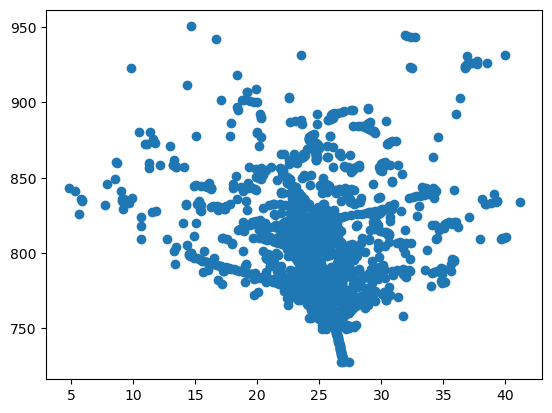

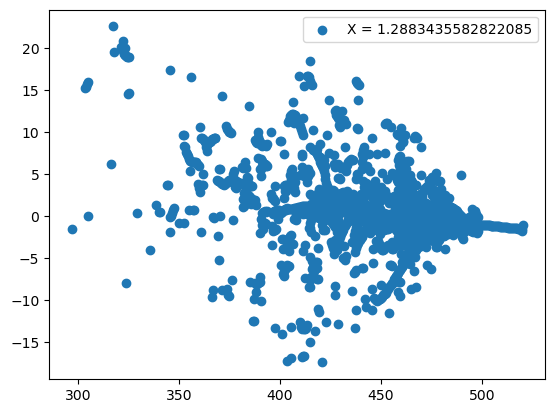

(array([1.28834356]), array([11.]))

In [37]:
symmetry(8960)